# Fouille données

In [2]:
!pip install pandas numpy matplotlib seaborn folium scikit-learn

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from collections import Counter

%matplotlib inline
sns.set(style="whitegrid")

# Importation des données

In [2]:
df = pd.read_csv('flickr_data2.csv', on_bad_lines='skip', sep=",")
print("Nombre de photos au départ :  " + str(len(df)))

Nombre de photos au départ :  420240


C:\Users\nputo\AppData\Local\Temp\ipykernel_22524\2839054439.py:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('flickr_data2.csv', on_bad_lines='skip', sep=",")


# Nettoyage des données

In [3]:
df.columns = df.columns.str.strip()

df_clean = df.dropna(axis=1, how='all')

cols_date = ['date_taken_year', 'date_taken_month', 'date_taken_day', 'date_taken_hour', 'date_taken_minute']

df_clean = df_clean.drop_duplicates(subset=['user', 'lat', 'long'] + cols_date)
df_clean = df_clean.dropna(subset=cols_date)

for col in cols_date:
    df_clean[col] = df_clean[col].astype(int)

colonnes_utiles = ['id', 'user', 'lat', 'long', 'tags', 'title'] + cols_date
df_clean = df_clean[colonnes_utiles]

print("\nDonnées nettoyées :")
display(df_clean.head())
print("Nombre de photos restantes : " + str(len(df_clean)))

pourcentage_supprimes = ((len(df) - len(df_clean)) / len(df)) * 100
print(f"Pourcentage de données supprimées : {pourcentage_supprimes:.2f}%")


Données nettoyées :


,id,user,lat,long,tags,title,date_taken_year,date_taken_month,date_taken_day,date_taken_hour,date_taken_minute
0,4395181099,30624617@N03,45.754858,4.821710,"chair,lyon,rhône,chaise,rhônealpes",Chaises avec vue,2010,2,28,15,11
1,4394748717,35853470@N00,45.753270,4.862953,NaN,NaN,2010,2,28,17,51
2,4394694699,11817998@N05,45.760655,4.846564,"365,iphone",59/365 - R46 V103 B163,2010,2,28,17,29
3,4394803790,11545749@N06,45.784000,4.874072,"nin,nineinchnails,gift,screening,toiou,avott",2010-01-29 Toiou Avott Lyon,2010,1,28,20,15
4,4394803554,11545749@N06,45.784000,4.874072,"lyon,nin,nineinchnails,gift,screening,toiou,avott",2010-01-28 Toiou Avott Lyon,2010,1,28,20,10


Nombre de photos restantes : 131973
Pourcentage de données supprimées : 68.60%


In [4]:
print(f"Année min : {df_clean['date_taken_year'].min()}")
print(f"Année max : {df_clean['date_taken_year'].max()}")

df_clean = df_clean[
    (df_clean['date_taken_year'] >= 2004) &
    (df_clean['date_taken_year'] <= 2026)
]

print(f"Année min : {df_clean['date_taken_year'].min()}")
print(f"Année max : {df_clean['date_taken_year'].max()}")
print("Après filtre temporel : " + str(len(df_clean)) + " photos.")

Année min : 1
Année max : 2238
Année min : 2004
Année max : 2019
Après filtre temporel : 131763 photos.


In [5]:
# Vérifier que les coordonnées géographiques sont cohérentes.
photos_avant_filtre = len(df_clean)

df_clean = df_clean[
    (df_clean['lat'] >= -90) & (df_clean['lat'] <= 90) &
    (df_clean['long'] >= -180) & (df_clean['long'] <= 180)
]
photos_supprimees = photos_avant_filtre - len(df_clean)
print(f"Photos supprimées par le filtre géographique : {photos_supprimees}")
print(f"Photos avec coordonnées valides : {len(df_clean)}")
print(f"Min/Max Latitude  : {df_clean['lat'].min()} / {df_clean['lat'].max()}")
print(f"Min/Max Longitude : {df_clean['long'].min()} / {df_clean['long'].max()}")

Photos supprimées par le filtre géographique : 0
Photos avec coordonnées valides : 131763
Min/Max Latitude  : 45.6552 / 45.85495
Min/Max Longitude : 4.720312 / 5.006709


In [6]:
from folium.plugins import FastMarkerCluster
# Création de la carte centrée sur une latitude et une longitude moyennes
m = folium.Map(location=[45.7640, 4.8357], zoom_start=13)
locations = list(zip(df['lat'], df['long']))
FastMarkerCluster(data=locations).add_to(m)
# Sauvegarde la carte dans un fichier HTML
m.save('ma_carte_lyon_old.html')
 

# Clustering

In [7]:
df_clustering = df_clean[['lat', 'long']]

In [8]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clustering)

# show
scaled_data_df = pd.DataFrame(data=scaled_data, columns=['lat', 'long'])

print("Aperçu des données standardisées (prêtes pour l'algo) :")
display(scaled_data_df.head())

print(f"Moyennes : \n{scaled_data_df.mean()}")

Aperçu des données standardisées (prêtes pour l'algo) :


,lat,long
0,-0.463766,-0.582759
1,-0.523591,0.851110
2,-0.245374,0.281324
3,0.634108,1.237677
4,0.634108,1.237677


Moyennes : 
lat    -7.243596e-14
long   -1.146075e-14
dtype: float64


## Estimation du nombre de clusters pour K-means via la méthode du coude 

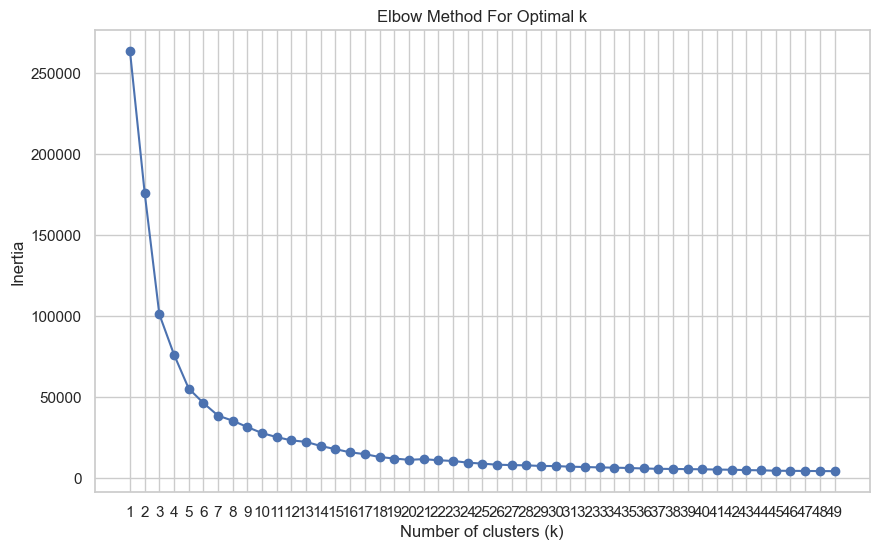

In [36]:
# Initialisation de la liste pour stocker les inerties
inertia = []
k_range = range(1, 50)  # On teste de 1 à 10 clusters

# Boucle pour calculer l'inertie pour chaque nombre de clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(scaled_data_df)
    inertia.append(kmeans.inertia_)

# Création du graphique (Plot)
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Au vu des résultats, nous pouvons partir sur une valeur entre 15 et 20. Cela permet d'avoir suffisant de zones d'intérêt pour une grande ville comme Lyon, tout en évitant de diviser les zones d'intéret en plusieurs cluster. Choisisons donc une valeur de 17 clusters.

## Utilisation de l'algorithme K-means

In [39]:
kmeans = KMeans(n_clusters=50, init='k-means++', random_state=42)

kmeans.fit(scaled_data_df)

df_clean['cluster'] = kmeans.labels_

df_clean.head()

,id,user,lat,long,tags,title,date_taken_year,date_taken_month,date_taken_day,date_taken_hour,date_taken_minute,cluster
0,4395181099,30624617@N03,45.754858,4.821710,"chair,lyon,rhône,chaise,rhônealpes",Chaises avec vue,2010,2,28,15,11,42
1,4394748717,35853470@N00,45.753270,4.862953,NaN,NaN,2010,2,28,17,51,6
2,4394694699,11817998@N05,45.760655,4.846564,"365,iphone",59/365 - R46 V103 B163,2010,2,28,17,29,31
3,4394803790,11545749@N06,45.784000,4.874072,"nin,nineinchnails,gift,screening,toiou,avott",2010-01-29 Toiou Avott Lyon,2010,1,28,20,15,35
4,4394803554,11545749@N06,45.784000,4.874072,"lyon,nin,nineinchnails,gift,screening,toiou,avott",2010-01-28 Toiou Avott Lyon,2010,1,28,20,10,35


In [11]:
import folium
from scipy.spatial import ConvexHull
import matplotlib.colors as mcolors

def generer_carte_clusters(df, nom_fichier="ma_carte.html"):
    """
    Génère une carte Folium avec des zones colorées selon la densité (Convex Hull).
    """
    
    # 1. Analyse des données
    filtered_data = df[df['cluster'] != -1]
    
    if filtered_data.empty:
        print("⚠️ Attention : Aucun cluster valide trouvé (tout est bruit ou vide).")
        return None

    counts = filtered_data['cluster'].value_counts()
    
    # Sécurité si le dataframe est vide ou n'a qu'un cluster
    if len(counts) == 0:
        print("Pas de données à afficher.")
        return None
        
    min_val = counts.min()
    max_val = counts.max()
    
    print(f"--- Génération de {nom_fichier} ---")
    print(f"Cluster min : {min_val} photos | Cluster max : {max_val} photos")

    # 2. Configuration des couleurs (Dégradé Blanc -> Rouge Foncé)
    colors = ["white", "blue", "red", "darkred"]
    cmap = mcolors.LinearSegmentedColormap.from_list("mon_degrade", colors)
    
    # Normalisation
    if min_val == max_val:
        norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    else:
        norm = mcolors.LogNorm(vmin=min_val, vmax=max_val)

    def get_color(n):
        return mcolors.to_hex(cmap(norm(n)))

    # 3. Création de la carte
    center_lat = df['lat'].mean()
    center_long = df['long'].mean()
    m = folium.Map(location=[center_lat, center_long], zoom_start=13)

    clusters_ids = sorted(df['cluster'].unique())

    # 4. Boucle de dessin
    for cluster_id in clusters_ids:
        if cluster_id == -1: 
            continue

        points = df[df['cluster'] == cluster_id][['lat', 'long']].values
        n_photos = len(points)
        
        color = get_color(n_photos)
        
        # Opacité dynamique
        opacity = 0.3 + (norm(n_photos) * 0.5) if max_val > min_val else 0.5

        # Cas A : Forme géométrique (Polygone)
        if len(points) >= 3:
            try:
                hull = ConvexHull(points)
                points_contour = points[hull.vertices]
                
                folium.Polygon(
                    locations=points_contour,
                    color=color,
                    weight=2,
                    fill=True,
                    fill_color=color,
                    fill_opacity=opacity,
                    popup=f"Zone {cluster_id}: {n_photos} photos"
                ).add_to(m)
                
                # Label au centre
                center = np.mean(points, axis=0)
                style_texte = "color: black; text-shadow: 1px 1px 0px white; font-weight: bold; font-size: 10pt;"
                folium.Marker(
                    center,
                    icon=folium.DivIcon(html=f'<div style="{style_texte}">{n_photos}</div>')
                ).add_to(m)
                
            except Exception:
                pass
                
        else:
            for pt in points:
                folium.CircleMarker(
                    pt, 
                    radius=5, 
                    color=color, 
                    fill=True, 
                    fill_color=color,
                    popup=f"Cluster {cluster_id}"
                ).add_to(m)

    # 5. Export
    m.save(nom_fichier)
    print(f"✅ Carte sauvegardée avec succès : {nom_fichier}\n")
    return m

In [40]:
generer_carte_clusters(df_clean, "carte_k_means")

--- Génération de carte_k_means ---
Cluster min : 160 photos | Cluster max : 13600 photos
✅ Carte sauvegardée avec succès : carte_k_means



## Utilisation de l'algorithme DBSCAN 

## Utilisation de l'algorithme DBSCAN 

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

eps_range = np.arange(0.1, 1.5, 0.1)
min_samples_range = range(2, 10)

best_score = -1
best_eps = -1
best_min_samples = -1

for eps in eps_range:
    for min_samples in min_samples_range:

        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(scaled_data_df)
        
        unique_labels = set(labels)
        if len(unique_labels) > 1:
            score = silhouette_score(scaled_data_df, labels)
            
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Best params found: eps={best_eps:.1f}, min_samples={best_min_samples}")
print(f"Best Silhouette Score: {best_score:.3f}")

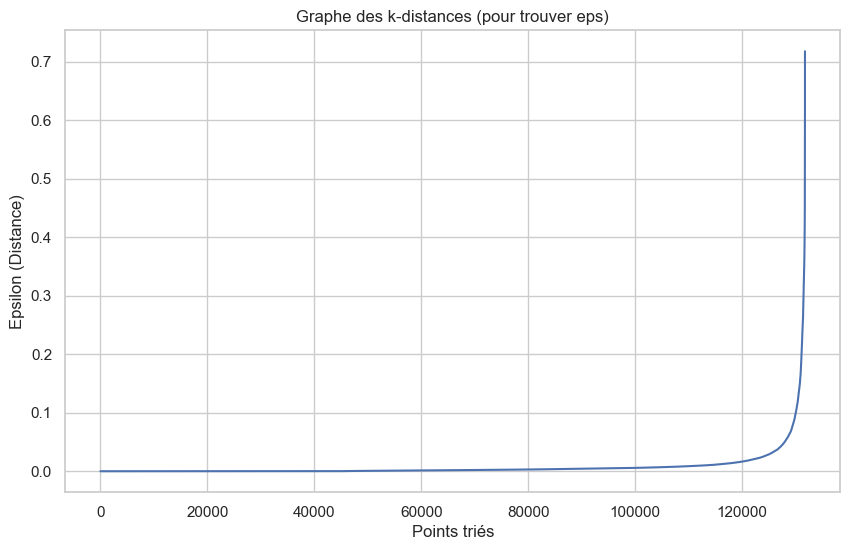

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

min_samples = 10

# 2. Calcul des voisins sur les données SCALÉES
# On regarde la distance vers le k-ième voisin
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(scaled_data_df)
distances, indices = neighbors_fit.kneighbors(scaled_data_df)

# 3. Tri des distances pour faire le graphique
distances = np.sort(distances[:, min_samples-1], axis=0)

# 4. Affichage
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title("Graphe des k-distances (pour trouver eps)")
plt.xlabel("Points triés")
plt.ylabel("Epsilon (Distance)")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

EPSILON_CHOISI = 0.004
MIN_SAMPLES = 50

print(f"Lancement de DBSCAN (eps={EPSILON_CHOISI}, min={MIN_SAMPLES})...")

# 1. Entraînement
dbscan = DBSCAN(eps=EPSILON_CHOISI, min_samples=MIN_SAMPLES)
clusters = dbscan.fit_predict(scaled_data_df)

df_clean['cluster'] = clusters

# 3. Petit rapport textuel
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)
percent_noise = (n_noise / len(df_clean)) * 100

print(f"--> Résultat : {n_clusters} clusters trouvés.")
print(f"--> Bruit : {n_noise} photos ignorées ({percent_noise:.1f}%)")

nom_fichier = f"carte_dbscan.html"
generer_carte_clusters(df_clean, nom_fichier)

Lancement de DBSCAN (eps=0.004, min=50)...
--> Résultat : 230 clusters trouvés.
--> Bruit : 74605 photos ignorées (56.6%)
--- Génération de carte_dbscan.html ---
Cluster min : 32 photos | Cluster max : 7737 photos
✅ Carte sauvegardée avec succès : carte_dbscan.html

